In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from util_visualization import plot_feature_importances, plot_roc_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import joblib
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import glob

## Adding Features

In [2]:
# Load the labeled index data from csv
labeled_index = pd.read_csv("../data/labeled_data/quarterly_labeled_index_standardized.csv")
# Concat the index data with features - Q1 1998 - Q4 2019
Marco_folder = "../data/Features_Marco"
Micro_folder = "../data/updatest"
csv_file_pattern = "*.csv"
Marco_csv_files = glob.glob(f"{Marco_folder}/{csv_file_pattern}")
Micro_csv_files = glob.glob(f"{Micro_folder}/{csv_file_pattern}")

#Marco
# Iterate over each CSV file in Marco_csv_files
for file in Marco_csv_files:
    data = pd.read_csv(file)
    # Get the file name from the CSV file path
    file_name = file.split('/')[-1]
    # Extract the index value from the file name
    new_name = file_name.split('.')[0]
    # Rename the 'Percentage Change' column to the index value
    data.rename(columns={'Percentage Change': new_name}, inplace=True)
    
    # Merge the data based on the specified conditions
    labeled_index = labeled_index.merge(data,
                                     how='left',
                                     left_on='Quarter',
                                     right_on='Quarter')


#Micro
# Iterate over each CSV file in csv_files
for file in Micro_csv_files:
    data = pd.read_csv(file)

    # Extract the header row and separate the index values
    header = data.columns[1:]  # Assuming the index values are in columns except the first one
    index_values = header.tolist()
    
    # Get the file name from the CSV file path
    file_name = file.split('/')[-1]
    # Extract the index value from the file name
    new_name = file_name.split('.')[0]
            
    # Create lists for the three columns
    quarter_column = []
    index_column = []
    file_name_column = []

    # Iterate through the data rows
    for row in data.itertuples(index=False):
        quarter = row[0]  # Extract the quarter value
        values = row[1:]  # Extract the values in the row

        # Iterate through the values and extract index and file name
        for index, file_name in zip(index_values, values):
            # Append the values to their respective columns
            quarter_column.append(quarter)
            index_column.append(index)
            file_name_column.append(file_name)

        
    # Create a DataFrame from the columns
    df = pd.DataFrame({'Quarter': quarter_column, 'index': index_column, new_name: file_name_column})


    # Merge the data based on the specified conditions
    labeled_index = labeled_index.merge(df,
                                        how='left',
                                        left_on=['Quarter', 'index'],
                                        right_on=['Quarter', 'index'])

# Define quarters
quarters = np.sort(labeled_index.index.unique())
print(labeled_index)

     volatility      index  crash_label  price_change  volume_change  \
0     -0.628541  000001.SS            0      0.187709      -0.127147   
1     -0.628541  000001.SS            0      0.504913      -0.127147   
2     -0.625680  000001.SS            1     -0.795446      -0.127147   
3     -0.631403  000001.SS            0     -0.843210      -0.127147   
4     -0.629515  000001.SS            0     -0.082838      -0.127147   
..          ...        ...          ...           ...            ...   
875   -0.493234      ^SSMI            0     -0.800378      -0.127147   
876   -0.529809      ^SSMI            0      0.914383      -0.127147   
877   -0.458321      ^SSMI            0      0.217264      -0.127147   
878   -0.388212      ^SSMI            0     -0.010617      -0.127147   
879   -0.351813      ^SSMI            0      0.296414      -0.127147   

           date  Quarter  Regional Feature  \
0     31/3/1998  Q1 1998                 1   
1     30/6/1998  Q2 1998                 1 

## Z-Score Standardization


In [3]:
# Rename the column
labeled_index = labeled_index.rename(columns={'Crude_Oil_Index_Excess_Return_Quarterly': 'Crude_Oil_Index_Excess_Return', 'TEDRATE_Quarterly': 'Ted_Rate', 'Goldprice_Quarterly': 'Gold_Price', 'Long-Term_Government_Bond Yields': '10YGov_BondYield'})

features_columns = list(labeled_index.columns)
columns_to_remove = ['index', 'crash_label', 'date', 'Quarter']
features_columns = [column for column in features_columns if column not in columns_to_remove]
print(features_columns)
# Handle extreme value
labeled_index['volume_change'].replace([np.inf], 1e10, inplace=True)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the selected data
scaled_features = scaler.fit_transform(labeled_index[features_columns])

# Replace the original columns with the scaled values
labeled_index[features_columns] = scaled_features

labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())

['volatility', 'price_change', 'volume_change', 'Regional Feature', 'Crude_Oil_Index_Excess_Return', 'Ted_Rate', 'Gold_Price', 'housing', 'reserve', '10YGov_BondYield', 'current_acct', 'FX_Rate', 'turnover', 'Population', 'npl', 'Recession_Indicators', 'inflation', 'Unemployment', 'GDP']


In [4]:
# Rename the column
labeled_index = labeled_index.rename(columns={'Crude_Oil_Index_Excess_Return_Quarterly': 'Crude_Oil_Index_Excess_Return', 'TEDRATE_Quarterly': 'Ted_Rate', 'Goldprice_Quarterly': 'Gold_Price', 'Long-Term_Government_Bond Yields': '10YGov_BondYield'})

In [5]:
# Save the merge_file DataFrame to a CSV file
labeled_index.to_csv("../data/labeled_data/quarterly_labeled_features_standardized.csv", index=False)

## Build the model

In [6]:
# Call TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []
shap_values_list = []

for train_index, test_index in tscv.split(quarters):
    
    train_quarters, test_quarters = quarters[train_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[features_columns]
    y_train = train['crash_label']
    X_test = test[features_columns]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE()
    X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

    # Hyperparameter Tuning
    param_grid = {"penalty": ['none', 'l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs', 'liblinear', 'sag', 'saga']}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=tscv, scoring='f1', verbose=2, error_score=0)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Best Score: {best_score}")
    print("Grid search completed successfully.")

    # Train the model
    model = LogisticRegression(C=best_params['C'], solver=best_params['solver'])
    model.fit(X_train_resampled, y_train_resampled)
    
    # Save the trained model to a file
    #joblib.dump(model, 'logistic_regression_model.joblib')
    print("prediction model trained")
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    
    # Predict probabilities on the test data
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    conf_matrix = confusion_matrix(y_test, y_pred, labels= [0,1])
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X_test)
    shap_values_list.append(shap_values)
    
    evaluation_result = {
        'Train_Start': pd.to_datetime(train_quarters).min(),
        'Train_End': pd.to_datetime(train_quarters).max(),
        'Test_Start': pd.to_datetime(test_quarters).min(),
        'Test_End': pd.to_datetime(test_quarters).max(),
        'Confusion_Matrix': conf_matrix,
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1, 
        'Accuracy': accuracy, 
        'RMSE': rmse,
        'MAPE': mape,
        'AUC-ROC': auc_roc,
        'False Positive Rate': fpr,
        'True Positive Rate': tpr
    }
    
    # Feature Importance
    feature_names = list(X_train.columns)
    feature_importance = model.coef_[0]
    for name, importance in zip(feature_names, feature_importance):
        evaluation_result[f"{name}_importance"] = importance

    # Append result to evaluation
    evaluation.append(evaluation_result)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..................C=0.001, penalty=none, solver=sag; total time=   0.0s
[CV] END ..................C=0.001, penalty=non

[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.0s
[CV] END ..................C

[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................

[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.0s
[CV] END .................C=1000, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .................C=1000, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .................C=1000, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .................C=1000, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .................C=1000, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .............C=1000, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .............C=1000, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .............C=1000, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .............C=1000, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .............C=1000, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...................C=1000, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END ...................C=0.01, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................C=0.01, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................C=0.01, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................C=0.01, penalty=none, solver=sag; total time=   0.0s
[CV] END ..................C=0.01, penalty=none, solver=saga; total time=   0.0s
[CV] END ..................C=0.01, penalty=none, solver=saga; total time=   0.0s
[CV] END ..................C=0.01, penalty=none, solver=saga; total time=   0.0s
[CV] END ..................C=0.01, penalty=none, solver=saga; total time=   0.0s
[CV] END ..................C=0.01, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................

[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ................C=1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ......................C=1, penalty=none, solver=sag; total time=   0.0s
[CV] END ......................C=1, penalty=none, solver=sag; total time=   0.0s
[CV] END ......................C=1, penalty=none, solver=sag; total time=   0.0s
[CV] END ......................C=1, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END ....................C=100, penalty=none, solver=sag; total time=   0.0s
[CV] END ....................C=100, penalty=none, solver=sag; total time=   0.0s
[CV] END ....................C=100, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................C=100, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=100, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=100, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=100, penalty=none, solver=saga; total time=   0.0s
[CV] END ...................C=100, penalty=none, solver=saga; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...................

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ................C=0.001, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ............C=0.001, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..................C=0.001, penalty=none, solver=sag; total time=   0.0s
[CV] END ..................C=0.001, penalty=non

[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END .....................C=100, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=1

[CV] END .................C=0.001, penalty=none, solver=saga; total time=   0.0s
[CV] END .................C=0.001, penalty=none, solver=saga; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.001, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...................

[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ..............C=0.1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.1, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.1, penalty=none, solver=sag; total time=   0.0s
[CV] END ....................C=0.1, penalty=none, solver=sag; total time=   0.0s
[CV] END ....................C=0.1, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .......................C=1, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................C=10, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END ...................

[CV] END ......................C=100, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=100, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   0.0s
[CV] END .................C=1000, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .................C=1000, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .................C=1000, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .................C=1000, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .................C=1000, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .............C=1000

[CV] END ...................C=0.001, penalty=l2, solver=saga; total time=   0.0s
[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .................C=0.01, penalty=none, solver=lbfgs; total time=   0.0s
[CV] END .............C=0.01, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, penalty=none, solver=liblinear; total time=   0.0s
[CV] END .............C=0.01, penalty=none, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.01, penalty=none, solver=sag; total time=   0.0s
[CV] END ...................

[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ......................C=0.1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=0.1, penalty=l2, solver=sag; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.0s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................

[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................

[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...................C=1000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=10

In [7]:
evaluation_df = pd.DataFrame(evaluation)
evaluation_df.to_csv('./evaluation_result/' + f"evaluation_Log_Regression_features.csv", index=False)
evaluation_df
#TODO: visualize it

,Train_Start,Train_End,Test_Start,Test_End,Confusion_Matrix,Precision,Recall,F1,Accuracy,RMSE,...,10YGov_BondYield_importance,current_acct_importance,FX_Rate_importance,turnover_importance,Population_importance,npl_importance,Recession_Indicators_importance,inflation_importance,Unemployment_importance,GDP_importance
0,1998-06-30,2015-06-30,1998-09-30,2019-06-30,"[[97, 19], [17, 7]]",0.269231,0.291667,0.280000,0.742857,0.507093,...,-0.003910,0.000625,0.032242,0.012819,0.069966,0.008818,0.017255,0.000625,-0.020220,0.030422
1,1998-06-30,2019-06-30,1998-12-31,2019-09-30,"[[107, 12], [10, 11]]",0.478261,0.523810,0.500000,0.842857,0.396412,...,-0.188948,0.042157,0.156475,0.108492,0.927761,-0.410307,0.474443,0.042157,-0.646296,0.167124
2,1998-06-30,2019-09-30,2000-12-31,2013-12-31,"[[113, 14], [3, 10]]",0.416667,0.769231,0.540541,0.878571,0.348466,...,-0.041310,0.033930,0.032846,0.024959,0.752862,-0.107686,0.560095,0.033930,-0.786418,-0.139138
3,1998-06-30,2019-09-30,1998-03-31,2019-12-31,"[[107, 23], [5, 5]]",0.178571,0.500000,0.263158,0.800000,0.447214,...,-0.091074,0.051014,-0.077327,0.074521,0.490134,-0.135732,0.557458,0.051014,-0.472224,-0.110056
4,1998-03-31,2019-12-31,2006-03-31,2019-03-31,"[[106, 18], [4, 12]]",0.400000,0.750000,0.521739,0.842857,0.396412,...,-0.020888,0.013647,0.017650,0.191494,0.516162,-0.010788,0.483717,0.013647,-0.284412,-0.032768


## Shap Values

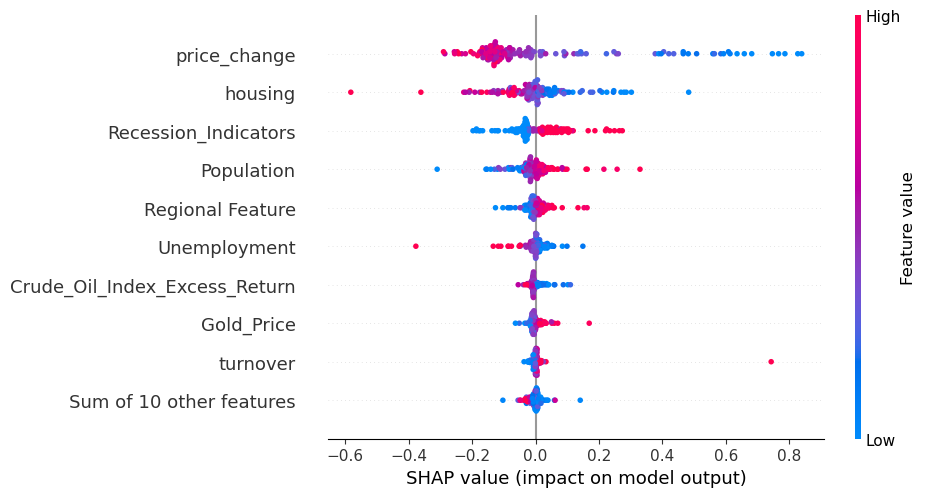

In [8]:
shap.plots.beeswarm(shap_values_list[4])

## Feature Importance

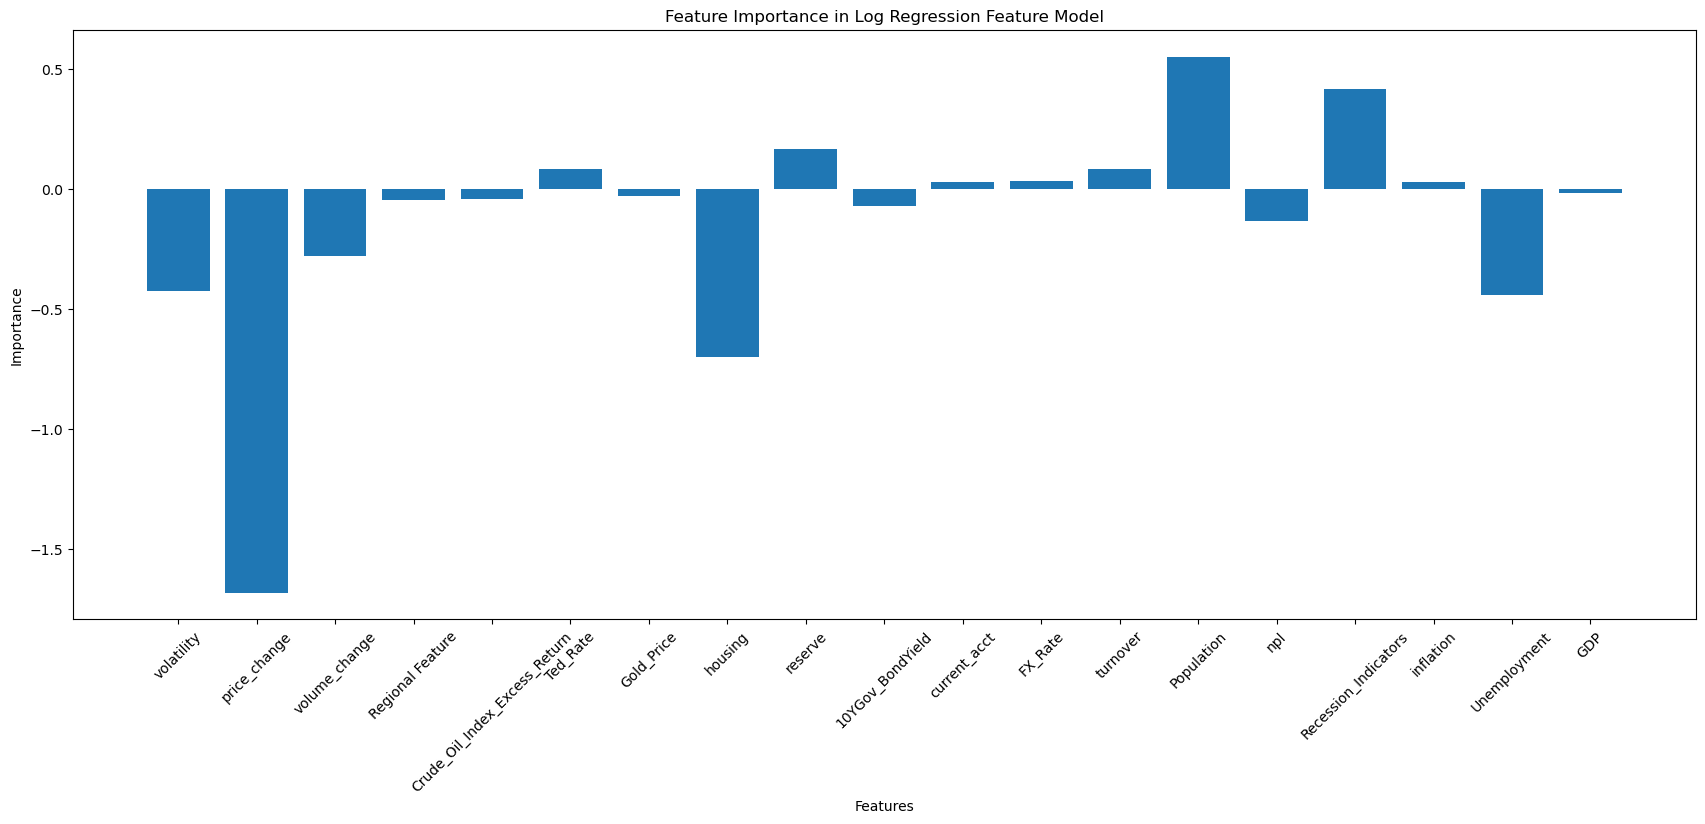

In [9]:
model_name = "Log Regression Feature"
plot_feature_importances(evaluation_df, model_name)

## AUC-ROC

In [10]:
print("Mean AUC Score: ", np.mean(evaluation_df['AUC-ROC']))

Mean AUC Score:  0.7573777631260771


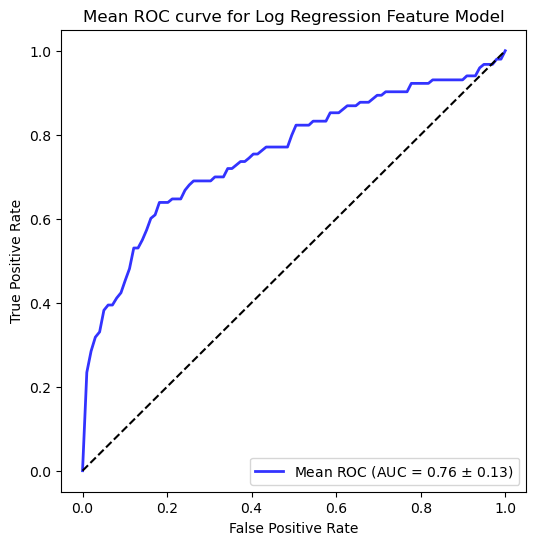

In [11]:
plot_roc_curve(evaluation_df, model_name)